In [ ]:
#import relevant libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Vis 1: all recommendations, aggregated by SDG regions or countries

In [ ]:
#read in UHRI data
with open('search-28_1_2021_69.json', 'r') as dat:
    df = pd.read_json(dat)

In [ ]:
#develop new variable for the number of countries tagged to each entry
df['NumberOfCountries'] = df['Countries'].apply(lambda x: len(x))

In [ ]:
#examine frequency distribution of the number of countries tagged to each entry
sns.displot(df, x="NumberOfCountries", discrete=True)

In [ ]:
df.NumberOfCountries.describe()

In [ ]:
#examine entries with more than one country
df.loc[(df.NumberOfCountries > 1)].Countries.describe()
df_kos = df.loc[(df.NumberOfCountries > 1)]
df_kos.tail(40)

In [ ]:
#create a row for each country tagged to each enty - i.e. expand the country list for each entry across multiple rows - for data fusion
df = df.explode('Countries')
df = df.reset_index(drop=True)

In [ ]:
#NB: explode extracts NaN from lists resulting in increase in null objects
#df_kos = df.loc[(df.NumberOfCountries < 1)]
df.groupby(['NumberOfCountries']).size().reset_index(name='count')

In [ ]:
#make Countries lower case and remove whitespace at either end of text
df['Countries'] = df['Countries'].astype(str)
df['Countries'] = df['Countries'].str.lower()
df['Countries'] = df['Countries'].apply(lambda x: x.strip())

In [ ]:
#read in data on country to SDG region mapping
with open('Master_coding_file.xlsx', 'rb') as dat:
    df_regions = pd.read_excel(dat, header= 0)

In [ ]:
#rename df_regions columns
df_regions.columns = ['ISOCode', 'Countries', 'SDGRegions']

In [ ]:
#make Countries in df_regions lower case and remove whitespace at either end of text
df_regions['Countries'] = df_regions['Countries'].astype(str)
df_regions['Countries'] = df_regions['Countries'].str.lower()
df_regions['Countries'] = df_regions['Countries'].apply(lambda x: x.strip())

In [ ]:
#test to check how many/which countries match up
test = df.groupby(['Countries']).size().reset_index(name='count')
other_values = test.iloc[:,0]
df_regions['Countries'].isin(other_values).describe()

In [ ]:
pd.set_option('max_rows', 200)
other_values
#UHRI contains "european union", "kosovo*", "nan" which do not exist in the SDG master coding file AND
#in UHRI "state of palestine*" need to delete the star AND "north macedonia" should be recoded as "republic of north macedonia"

In [ ]:
#implementing needed changes from cell above
df['Countries'] = df['Countries'].str.replace("*", "")
df['Countries'] = df['Countries'].replace({'north macedonia': 'republic of north macedonia'})

In [ ]:
df.shape

In [ ]:
#merge datasets, adding the 'ISOCode' and 'SDGRegions' variables to the df
df_vis1 = pd.merge(df, df_regions, how='left', on='Countries')

In [ ]:
df_vis1.shape

In [ ]:
#Checking that NaN entries in the new SDGRegions column correspond to 'kosovo', 'nan', 'european union' in the Countries column
#df_vis1.SDGRegions.describe()
df_vis1.SDGRegions.isnull().sum()
#df_vis1.loc[df_vis1.SDGRegions.isnull()].Countries.unique()

121

In [ ]:
#Dropping the NaN entries in the new SDGRegions column
df_vis1 = df_vis1[df_vis1['SDGRegions'].notna()]
#should lose 121 rows, resulting in 73,278 rows
df_vis1.shape

(73278, 17)

Vis 1a: all entries aggregated by SDG region

In [ ]:
#sum entries for each region
df_vis1_regions = df_vis1.groupby(['SDGRegions']).size().reset_index(name='count')
df_vis1_regions.columns = ['Region', 'Count']
df_vis1_regions = df_vis1_regions.sort_values(by=['Count'], ascending=False)

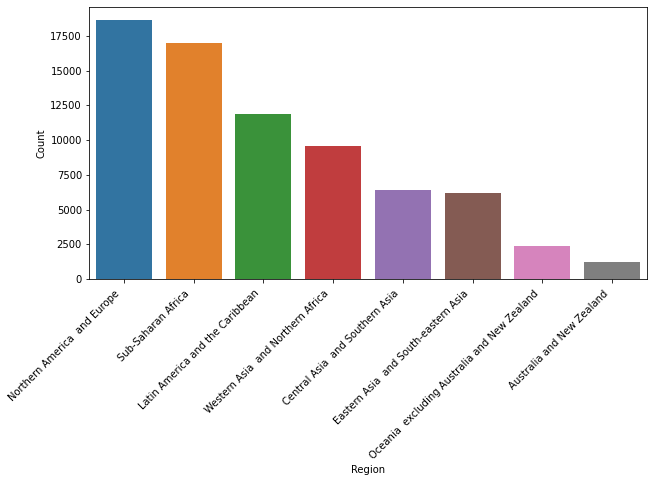

In [ ]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x="Region", y="Count", data=df_vis1_regions)

labels= chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize= 10
)

Vis 1b: all entries aggregated by country

In [ ]:
#sum entries for each country
df_vis1_countries = df_vis1.groupby(['Countries']).size().reset_index(name='count')
df_vis1_countries.columns = ['Country', 'Count']
df_vis1_countries = df_vis1_countries.sort_values(by=['Count'], ascending=False)

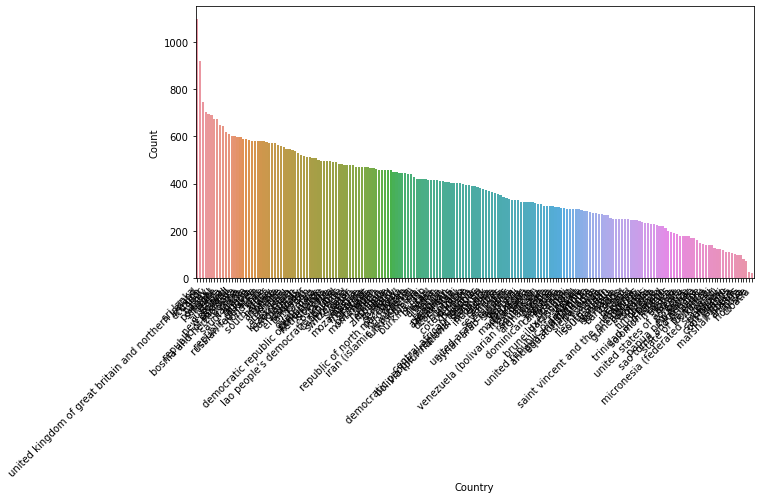

In [ ]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x="Country", y="Count", data=df_vis1_countries)

labels= chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize= 10
)

In [ ]:
#need to turn this into a map-based visualisation
df_vis1_countries.to_csv('countries_data_for_vis.csv')

In [ ]:
pip install geopandas

In [ ]:
import geopandas

df_world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

In [ ]:
df_world.plot()

In [ ]:
df_world.head()

In [ ]:
df_vis1_iso = df_vis1.groupby(['ISOCode']).size().reset_index(name='count')
df_vis1_iso.columns = ['Country', 'Count']
df_vis1_iso = df_vis1_iso.sort_values(by=['Count'], ascending=False)

In [ ]:
df_merged_map = df_world.set_index("iso_a3").join(df_vis1_iso.set_index('Country'))

In [ ]:
df_merged_map.tail()

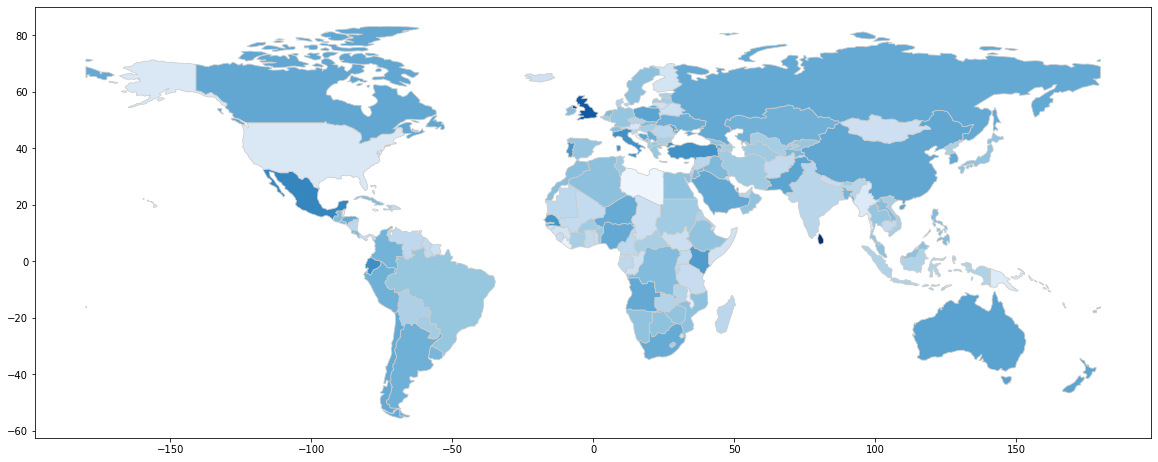

In [ ]:
vmin, vmax = 120, 220
fig, ax = plt.subplots(1, figsize=(20, 12))
df_merged_map.plot(column="Count", cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

#Vis 2: total recommendations per COVID HR issue, disaggregated by SDG regions

In [ ]:
#read in UHRI data
with open('search-28_1_2021_69.json', 'r') as dat:
    df = pd.read_json(dat)

In [ ]:
#develop new variable for the number of countries tagged to each entry
df['NumberOfCountries'] = df['Countries'].apply(lambda x: len(x))

In [ ]:
#examine entries with more than one country
df.loc[(df.NumberOfCountries > 1)].Countries.describe()
#df_kos = df.loc[(df.NumberOfCountries > 1)]
#df_kos.tail(40)

In [ ]:
#create a row for each country tagged to each enty - i.e. expand the country list for each entry across multiple rows - for data fusion
df = df.explode('Countries')
df = df.reset_index(drop=True)

In [ ]:
#notes: explode extracts NaN from lists resulting in increase in null objects
#df_kos = df.loc[(df.NumberOfCountries < 1)]
df.groupby(['NumberOfCountries']).size().reset_index(name='count')

In [ ]:
#make Countries lower case and remove whitespace at either end of text
df['Countries'] = df['Countries'].astype(str)
df['Countries'] = df['Countries'].str.lower()
df['Countries'] = df['Countries'].apply(lambda x: x.strip())

In [ ]:
#read in data on country to SDG region mapping
with open('Master_coding_file.xlsx', 'rb') as dat:
    df_regions = pd.read_excel(dat, header= 0)

In [ ]:
#rename df_regions columns
df_regions.columns = ['ISOCode', 'Countries', 'SDGRegions']

In [ ]:
#make Countries in df_regions lower case and remove whitespace at either end of text
df_regions['Countries'] = df_regions['Countries'].astype(str)
df_regions['Countries'] = df_regions['Countries'].str.lower()
df_regions['Countries'] = df_regions['Countries'].apply(lambda x: x.strip())

In [ ]:
#test to check how many/which countries match up
test = df.groupby(['Countries']).size().reset_index(name='count')
other_values = test.iloc[:,0]
df_regions['Countries'].isin(other_values).describe()

In [ ]:
pd.set_option('max_rows', 200)
other_values
#UHRI contains "european union", "kosovo*", "nan" which do not exist in the SDG master coding file AND
#in UHRI "state of palestine*" need to delete the star AND "north macedonia" should be recoded as "republic of north macedonia"

In [ ]:
#implementing needed changes from cell above
df['Countries'] = df['Countries'].str.replace("*", "")
df['Countries'] = df['Countries'].replace({'north macedonia': 'republic of north macedonia'})

In [ ]:
#merge datasets, adding the 'ISOCode' and 'SDGRegions' variables to the df
df = pd.merge(df, df_regions, how='left', on='Countries')

In [ ]:
#Checking that NaN entries in the new SDGRegions column correspond to 'kosovo', 'nan', 'european union' in the Countries column
#df.SDGRegions.describe()
#df.SDGRegions.isnull().sum()
df.loc[df.SDGRegions.isnull()].Countries.unique()

In [ ]:
#Dropping the NaN entries in the new SDGRegions column
df = df[df['SDGRegions'].notna()]
#should lose 121 rows, resulting in 73,278 rows
df.shape

(73278, 16)

Data wrangling for "leave noone behind"

In [ ]:
df_lnob = df.copy()

In [ ]:
df_lnob.columns

In [ ]:
#create new variable for the number of affected persons tagged to each entry
df_lnob['NumberOfAPs'] = df_lnob['AffectedPersons'].apply(lambda x: len(x))

In [ ]:
#examine frequency distribution of the number of Affected Persons tagged to each entry
sns.displot(df_lnob, x="NumberOfAPs", discrete=True)

In [ ]:
#total number of affected persons tagged across all entries
df_lnob['NumberOfAPs'].sum()

In [ ]:
#create a row for each affected person tagged to each entry
df_lnob = df_lnob.explode('AffectedPersons')
df_lnob = df_lnob.reset_index(drop=True)

In [ ]:
#remove whitespace at either end of text
df_lnob['AffectedPersons'] = df_lnob['AffectedPersons'].astype(str)
df_lnob['AffectedPersons'] = df_lnob['AffectedPersons'].apply(lambda x: x.strip())

In [ ]:
df_lnob.AffectedPersons.unique()

In [ ]:
#Filter relevant affected persons
relevant_APs = ['Persons living in poverty', 'Roma, Gypsies, Sinti & Travellers',
       'Migrants', 'Vulnerable persons/groups',
       'Minorities/ racial, ethnic, linguistic, religious or descent-based groups',
       'Refugees & asylum seekers',
       'Lesbian, gay, bisexual and transgender and intersex persons (LGBTI)',
       'Persons with disabilities',
       'Children in vulnerable situations (abused, living on the street, institutionalized, indigenous, migrant children etc.)',
       'Older persons', 'Women & girls', 'Children',
       'Human rights defenders & activists',
       'Internally displaced persons', 'Persons living in rural areas',
       'Persons affected by armed conflict',
       'Media', 'Youth & juveniles',
       'Indigenous peoples', 'People of African Descent',
       'Persons deprived of their liberty & detainees',
       'Educational staff & students', 'Disappeared persons',
       'Non-citizens',
       'Medical staff / health professionals',
       'Persons living with HIV/AIDS',
       'Stateless persons', 'Persons living with albinism',
       'Domestic workers']
condition = df_lnob.AffectedPersons.isin(relevant_APs)
df_lnob = df_lnob[condition].copy()

In [ ]:
#read in data on consolidated list of affected person categories
with open('affected_persons_consolidated.xlsx', 'rb') as dat:
    df_aps_cons = pd.read_excel(dat, header= 0)

In [ ]:
df_aps_cons.columns = ['AffectedPersons', 'AffectedPersonsConsolidated']

In [ ]:
#remove whitespace at either end of text
df_aps_cons['AffectedPersons'] = df_aps_cons['AffectedPersons'].astype(str)
df_aps_cons['AffectedPersons'] = df_aps_cons['AffectedPersons'].apply(lambda x: x.strip())

In [ ]:
#merge datasets, adding the 'AffectedPersonsConsolidated' variable to the df
df_lnob = pd.merge(df_lnob, df_aps_cons, how='left', on='AffectedPersons')

In [ ]:
df_lnob = df_lnob.groupby(['SDGRegions', 'AffectedPersonsConsolidated']).size().reset_index(name='count')

In [ ]:
#need to pivot the df for the stacked barplot
df_lnob = df_lnob.pivot(index='AffectedPersonsConsolidated', columns='SDGRegions')
df_lnob = df_lnob['count'].reset_index()
df_lnob.columns.name = None

In [ ]:
df_lnob.columns = ['Affected Person Categories','Australia and New Zealand',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Latin America and the Caribbean', 'Northern America and Europe',
       'Oceania excluding Australia and New Zealand', 'Sub-Saharan Africa', 'Western Asia and Northern Africa']

In [ ]:
#scale the columns to sum to 1
df_lnob_vis2 = df_lnob.apply(lambda x: x/x.sum() if x.name in ['Australia and New Zealand',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Latin America and the Caribbean', 'Northern America and Europe',
       'Oceania excluding Australia and New Zealand', 'Sub-Saharan Africa', 'Western Asia and Northern Africa'] else x)

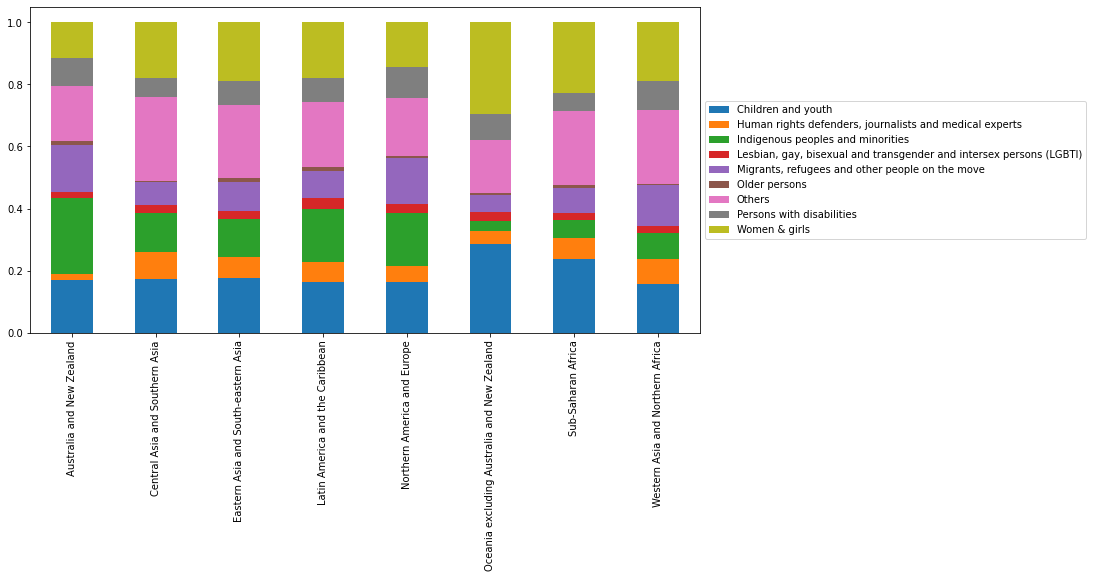

In [ ]:
df_lnob_vis2.set_index('Affected Person Categories').T.plot(kind='bar', stacked=True, figsize=(12,6)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
#df_lnob_vis2
df_lnob_vis2.to_csv('data_for_vis_leave_no_one_behind_scaled.csv')

Data wrangling for the other themes -> COVID human rights indicators


In [ ]:
#back to using the df from the earier section
df.shape
df.columns

In [ ]:
#develop new variable for the number of themes tagged to each entry
df['NumberOfThemes'] = df['Themes'].apply(lambda x: len(x))

In [ ]:
#examine frequency distribution of the number of themes tagged to each entry
sns.displot(df, x="NumberOfThemes", discrete=True)

In [ ]:
#examing the theme variable of one entry to view structure
df.iloc[0, 8]

['Cooperation & Follow up with Treaty Bodies',
 'Racial discrimination',
 ' Scope of international obligations',
 'Right to adequate housing']

In [ ]:
#total number of themes tagged across all entries
df['NumberOfThemes'].sum()

224345

In [ ]:
#create a row for each theme tagged to each enty - i.e. expand the theme list for each entry across multiple rows - for data fusion
df = df.explode('Themes')
df = df.reset_index(drop=True)

In [ ]:
#make theme lower case and remove whitespace at either end of theme text
df['Themes'] = df['Themes'].astype(str)
df['Themes'] = df['Themes'].str.lower()
df['Themes'] = df['Themes'].apply(lambda x: x.strip())

In [ ]:
#read in the data mapping UHRI themes to COVID human rights indicators
with open('Mapping_covid_UHRI.xlsx', 'rb') as dat:
    df_map = pd.read_excel(dat, header= 0)

In [ ]:
#make UHRI theme lower case and remove whitespace at either end of theme text
#df_map = df_map.drop(2)
df_map['UHRI themes'] = df_map['UHRI themes'].str.lower()
df_map['UHRI themes'] = df_map['UHRI themes'].apply(lambda x: x.strip())
#Rename columns
df_map.columns = ['COVID Human Rights Indicator', 'Themes']
#df_map

In [ ]:
some_values = df_map.iloc[:,1]
df = df.loc[df['Themes'].isin(some_values)]
df = df.reset_index(drop=True)

In [ ]:
df_vis2 = pd.merge(df, df_map, how='left', on='Themes')

In [ ]:
#test to check that all UHRI themes of interest were captured
test = df_vis2.groupby(['Themes']).size().reset_index(name='count')
other_values = test.iloc[:,0]
df_map['Themes'].isin(other_values)

In [ ]:
df_vis2 = df_vis2.groupby(['SDGRegions', 'COVID Human Rights Indicator']).size().reset_index(name='count')
df_vis2.columns = ['SDG Region', 'COVID Human Rights Indicator', 'Count']

In [ ]:
#Sort values
df_vis2 = df_vis2.sort_values(by=['SDG Region','COVID Human Rights Indicator']).reset_index(drop=True)

In [ ]:
#need to pivot the df for the stacked barplot
df_vis2 = df_vis2.pivot(index='COVID Human Rights Indicator', columns='SDG Region')
df_vis2 = df_vis2['Count'].reset_index()
df_vis2.columns.name = None

In [ ]:
df_vis2.columns = ['COVID Human Rights Indicator','Australia and New Zealand',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Latin America and the Caribbean', 'Northern America and Europe',
       'Oceania excluding Australia and New Zealand', 'Sub-Saharan Africa', 'Western Asia and Northern Africa']

In [ ]:
#scale the columns to sum to 1
df_vis2 = df_vis2.apply(lambda x: x/x.sum() if x.name in ['Australia and New Zealand',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Latin America and the Caribbean', 'Northern America and Europe',
       'Oceania excluding Australia and New Zealand', 'Sub-Saharan Africa', 'Western Asia and Northern Africa'] else x)

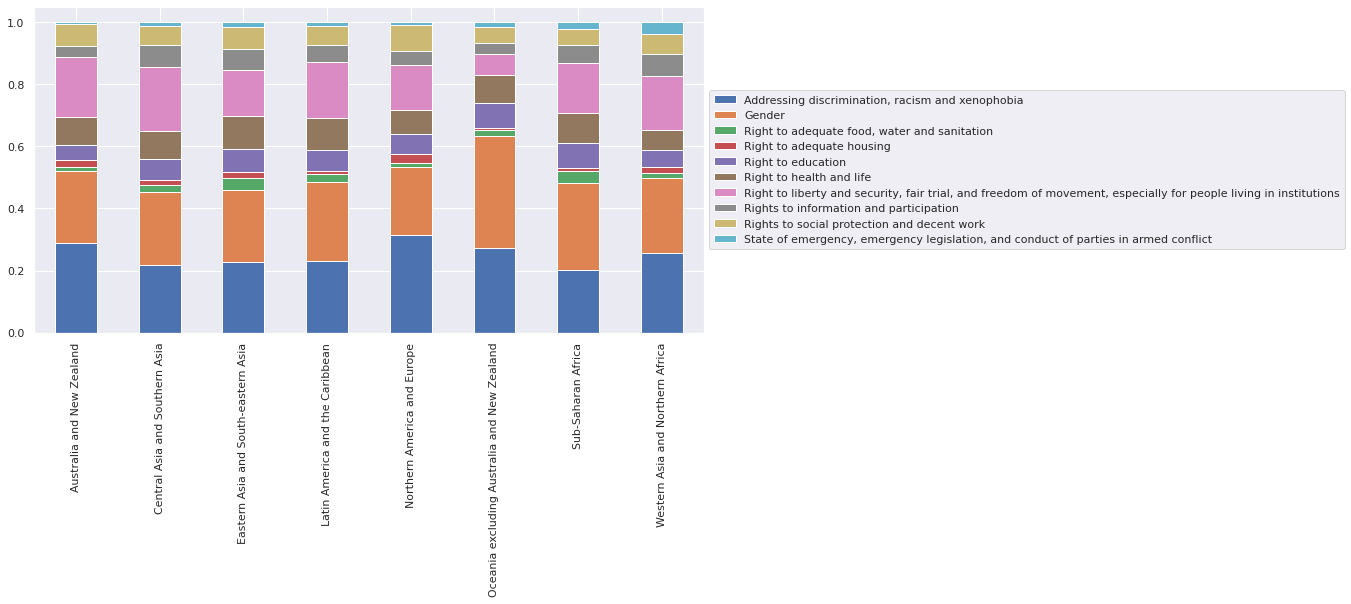

In [ ]:
sns.set()
df_vis2.set_index('COVID Human Rights Indicator').T.plot(kind='bar', stacked=True, figsize=(12,6)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
df_vis2.to_csv('data_for_vis_covid_hr_indicators.csv')

Data wrangling for the SDG vis


In [ ]:
#read in UHRI data
with open('search-28_1_2021_69.json', 'r') as dat:
    df = pd.read_json(dat)

In [ ]:
#develop new variable for the number of SDGs tagged to each entry
df['NumberOfSDGs'] = df['Sdgs'].apply(lambda x: len(x))

In [ ]:
#examine frequency distribution of the number of SDGs tagged to each entry
sns.displot(df, x="NumberOfSDGs", discrete=True)

In [ ]:
df.NumberOfSDGs.describe()

In [ ]:
#create a row for each SDG tagged to each entry
df = df.explode('Sdgs')
df = df.reset_index(drop=True)

In [ ]:
#df.loc[df.Sdgs.notna()].Sdgs.unique()
sdg_list = df.Sdgs.unique()

In [ ]:
sdg_df = pd.DataFrame(sdg_list, columns=['SDGs_raw'])

In [ ]:
sdg_df["SDGs"] = sdg_df.SDGs_raw.str.extract('(\d+)')

In [ ]:
sdg_df["SDG_indicator"] = sdg_df.SDGs_raw.str.extract('(\d+\.\d+|\d+)')

In [ ]:
sdg_df.columns = ['Sdgs', 'SDG_goal', 'SDG_indicator']

In [ ]:
df = pd.merge(df, sdg_df, how='left', on='Sdgs')

In [ ]:
df.columns

In [ ]:
df.Body.unique()

In [ ]:
df['Body'] = df['Body'].apply(lambda x: x.replace('- ', ''))
df['Body'] = df['Body'].apply(lambda x: x.strip())
df['Body'] = df['Body'].str.lower()

In [ ]:
#read in the data mapping HR mechanisms to HR mechanism categories
with open('mechanism_types.xlsx', 'rb') as dat:
    df_mechanisms = pd.read_excel(dat, header= 0)

df_mechanisms = df_mechanisms.iloc[:,1:3]
df_mechanisms.columns = ['Body', 'Human Rights Mechanism']

In [ ]:
df_mechanisms['Body'] = df_mechanisms['Body'].apply(lambda x: x.strip())
df_mechanisms['Body'] = df_mechanisms['Body'].str.lower()

In [ ]:
df.loc[df.Body.isnull()].Body.sum() #isnull() #notna() #unique()

In [ ]:
df.Body.describe()

In [ ]:
df = pd.merge(df, df_mechanisms, how='left', on='Body')

In [ ]:
df["Human Rights Mechanism"].describe() #difference is due to whitespace not being classed as NAN

In [ ]:
df.loc[df["Human Rights Mechanism"].isnull()]

In [ ]:
df_sdg = df.groupby(['SDG_goal', 'Human Rights Mechanism']).size().reset_index(name='count')
df_sdg.columns = ['SDG', 'Human Rights Mechanism', 'Count']
df_sdg['SDG'] = df_sdg['SDG'].astype(int)
df_sdg = df_sdg.sort_values(by=['SDG', 'Human Rights Mechanism']).reset_index(drop=True)

In [ ]:
df_sdg

In [ ]:
df_sdg.to_csv('data_for_vis_sdg.csv')